In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.optim import SGD, Adam

In [43]:
mu = torch.ones(2)
sigma = torch.eye(2)
learning_rate = 1e-1
epsilon = 3.
num_epochs = 30
c = 0.1
TEST_SIZE = 300
TRAIN_SIZE = 30
BEST_MODEL_PATH = 'best_svm_model.pt'

In [44]:
x_test = torch.cat([torch.distributions.MultivariateNormal(-mu, sigma).sample((TEST_SIZE,)), torch.distributions.MultivariateNormal(mu, sigma).sample((TEST_SIZE,))]).float()
y_test = torch.unsqueeze(torch.cat([-torch.ones(TEST_SIZE), torch.ones(TEST_SIZE)]), dim=1).float()
test_set = Data.TensorDataset(x_test, y_test)
test_loader = Data.DataLoader(dataset=test_set, batch_size=TEST_SIZE//10, shuffle=False)

In [45]:
def train_hinge_loss(x, y, weight, bias):
    loss = torch.mean(torch.clamp(1 - y * (x @ weight - bias), min=0))
    loss += c * ((weight.t() @ weight) / 2.0).item()
    return loss

In [46]:
def test_hinge_loss(x, y, weight, bias):
    return torch.mean(torch.clamp(1 - y * (x @ weight - bias), min=0))

In [47]:
def fgsm(model, x, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    x.requires_grad = True
    output = model(x)

    loss = train_hinge_loss(x, y, model.weight.t(), model.bias)
    model.zero_grad()
    loss.backward()
    return epsilon * x.grad.data.sign()

In [48]:
def fit(num_epochs, train_loader, model, loss_fn, opt):
    model.train()
    best_loss = float('inf')
    for epoch in range(num_epochs):
        sum_loss = 0
        for x, y in train_loader:
            opt.zero_grad()
            delta = fgsm(model, x, y, epsilon)
            # perturbed training data
            x_pert = x + delta
            # predicted output
            y_pred = model(x_pert)
#             print(x[0])
#             print('---')
#             print(x_pert[0])
        
#             y_pred = model(x)
            weight = model.weight.t() # .squeeze()
            bias = model.bias
            loss = train_hinge_loss(x_pert, y, weight, bias)
            loss.backward()
            opt.step()
            sum_loss += float(loss)
        epoch_train_loss = sum_loss / train_size
        if epoch_train_loss < best_loss:
            best_loss = epoch_train_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH)
#         print("Epoch:", epoch)
#         print("Training loss:", sum_loss / train_size)
    # calc test loss

    sum_test_loss = 0
    model = nn.Linear(2, 1)
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
    model.eval()
    for x, y in test_loader:
        weight = model.weight.t()
        bias = model.bias
        loss = test_hinge_loss(x, y, weight, bias)
        sum_test_loss += loss
    #     print('Training loss: ', loss_fn(model(x_train), y_train))
#     print('Test loss: ', test_loss / test_size)
    return sum_test_loss / TEST_SIZE

In [49]:
# EPSILONS = np.array([0.3, ])
test_losses = np.zeros(TRAIN_SIZE)

for train_size in range(1, TRAIN_SIZE+1):
    N = 30
    temp = np.zeros(N)
    for i in range(N):
        model = nn.Linear(2, 1)
        opt = Adam(model.parameters(), lr=learning_rate)
        batch_size = min(5, train_size)
        x_train = torch.cat([torch.distributions.MultivariateNormal(-mu, sigma).sample((train_size,)), torch.distributions.MultivariateNormal(mu, sigma).sample((train_size,))]).float()
        y_train = torch.unsqueeze(torch.cat([-torch.ones(train_size), torch.ones(train_size)]), dim=1).float()
        train_set = Data.TensorDataset(x_train, y_train)
        train_loader = Data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
        test_loss = fit(num_epochs, train_loader, model, test_hinge_loss, opt)
        temp[i] = test_loss.item()
    # test_losses[train_size-1] = test_loss.item()


#     median = np.median(temp)
    mean = np.mean(temp)
#     test_losses[train_size-1] = median.item()
    test_losses[train_size-1] = mean.item()


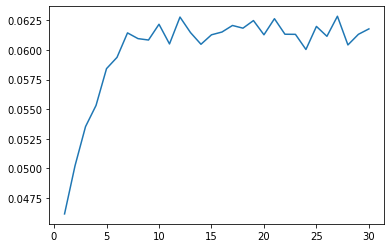

In [50]:
train_sizes = np.arange(1, TRAIN_SIZE+1)
plt.plot(train_sizes, test_losses)

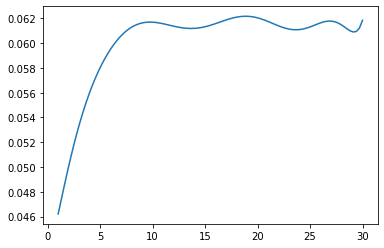

In [51]:
train_sizes = np.arange(1, TRAIN_SIZE+1)

poly_reg = np.poly1d(np.polyfit(train_sizes, test_losses, 10))
x = np.linspace(train_sizes.min(), train_sizes.max(), 100)

plt.plot(x, poly_reg(x))

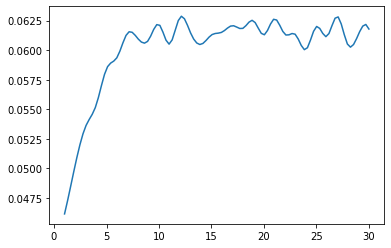

In [52]:
from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max
train_sizes = np.arange(1, TRAIN_SIZE+1)
x = np.linspace(train_sizes.min(), train_sizes.max(), 100)
spline = make_interp_spline(train_sizes, test_losses, k=3)  # type: BSpline
y = spline(x)

plt.plot(x, y)

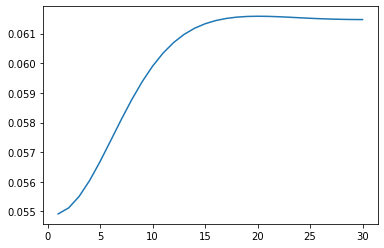

In [53]:
from scipy.ndimage import gaussian_filter1d

train_sizes = np.arange(1, TRAIN_SIZE+1)

test_losses_smoothed = gaussian_filter1d(test_losses, sigma=5)
plt.plot(train_sizes, test_losses_smoothed)

In [54]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0570, -0.0100]], requires_grad=True),
 Parameter containing:
 tensor([-0.3433], requires_grad=True)]